# Parameterizing Vertical Mixing Coefficients in the Ocean Surface Boundary Layer Using Neural Networks

### Group 2: Juan Palacios Godoy, Kefeng Shi, Yutong Wang, Sam Anwar

In this notebook, we expand upon the work from **Sane et al. (2023) "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks." Journal of Advances in Modeling Earth Systems 15.10: [e2023MS003890](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS003890)**. We extend the work in three ways:

1. [Independent component analysis (ICA)](#3.-Independent-Component-Analysis-(ICA))
2. [Sparse Gaussian Process Regression (GPR)](#4.-Sparse-Gaussian-Process-Regression-(GPR))
3. [Gaussian Features](#5.-Gaussian-Features)

# 1. Setup workspace and Import packages

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

!pip install gpytorch
!pip install matplotlib

In [2]:
import time

start_time = time.time()

import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
import gpytorch

from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff_og
import lib.func_file_pca as ff_pca
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores
from lib.sparse_gpr_viz import *

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/climate-ml-project2-parametrization-group2/Group-2/Project2-Parameterization


# 2. Data 

In [3]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


## 2.1 Data Filtering
To ensure high-quality and valid data for training, specific filtering criteria are applied by Sane et al. (2023):

1. Heat flux ($ \text{heat} $) magnitude below 601 $ W/m^2 $.
2. Wind stress ($ \text{tx} $) below 1.2 $ N/m^2 $.
3. Boundary layer depth ($ \text{h} $) between 30 m and 300 m.

In [4]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [5]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load_pca=copy.deepcopy(data_load_main)
data_load_gpr=copy.deepcopy(data_load_main)

<a id='ica'></a>
# 3. Independent Component Analysis (ICA)

## 3.1 Preprocessing

In our first extension in this project, we preprocess the training data by applying ICA with 14 components (also tried PCA with 10 components) in order to reduce the model to retain the most influential information and streamline further analysis. On the one hand, ICA allows us reduce the dimensionality of the data while still capturing its variance. On the other hand, it also allows us to build independent components used to facilitate the training of the neural network. Our hypothesis was that this would add efficiency to our model.

In [6]:
__N_COMPONENTS__= 14
__DIM_RED_MODEL__ = 'ICA'
train_data_obj = ff_pca.preprocess_train_data_2(data_load_pca, 
                                                dimension_reduction_model=__DIM_RED_MODEL__,
                                                dimension_reduction_n_components=__N_COMPONENTS__) 

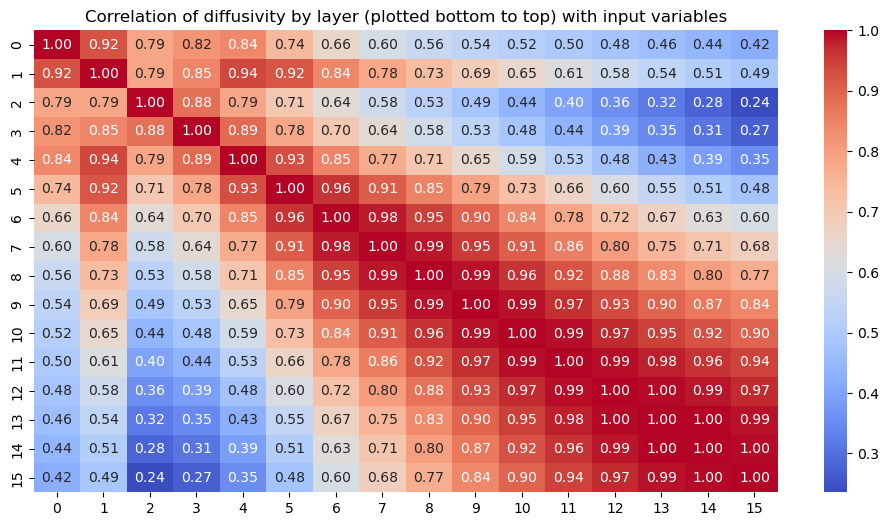

In [11]:
df = pd.DataFrame(data_load_pca[:, 4:])
correlation_matrix = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of diffusivity by layer (plotted bottom to top) with input variables")
plt.show()

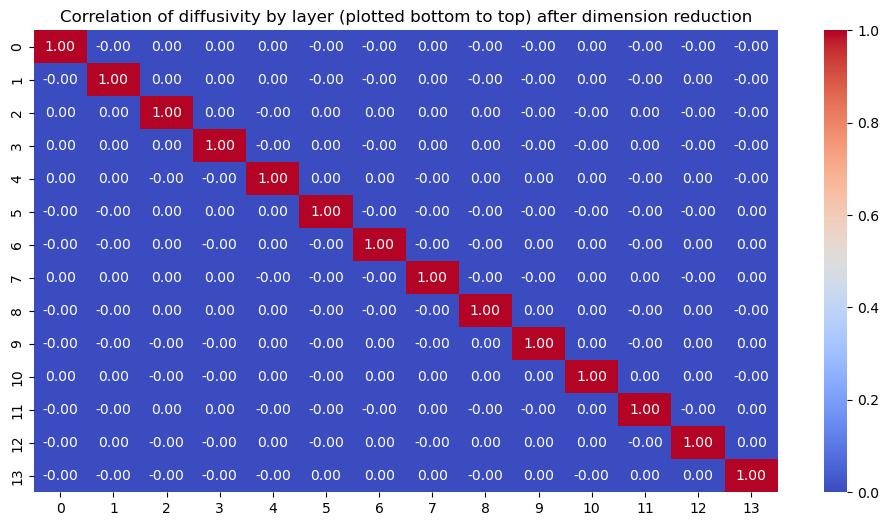

In [12]:
df = pd.DataFrame(train_data_obj.endogenous_data())

correlation_matrix = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of diffusivity by layer (plotted bottom to top) after dimension reduction")
plt.show()

## 3.2 Validation Dataset

In this project, training and validation datasets are generated independently through separate simulations. This practice ensures **strict independence** between the two datasets, avoiding issues like **data leakage** or overfitting. 

Like our training dataset, the validation dataset is preprocessed with ICA (14 components).

In [13]:
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_data=np.concatenate((valid_data[ind,0:4],valid_data[ind,5:]), axis=1)

validation_data_obj = ff_pca.get_data_object(data=valid_data,
                                             dimension_reduction_model=__DIM_RED_MODEL__,
                                             dimension_reduction_n_components=__N_COMPONENTS__,
                                             mean_override=train_data_obj.transformed_mean,
                                             std_override=train_data_obj.transformed_std)


In [14]:
x=torch.FloatTensor(train_data_obj.exogenous_data()).to(device)
y=torch.FloatTensor(train_data_obj.endogenous_data()).to(device)

valid_x=torch.FloatTensor(validation_data_obj.exogenous_data()).to(device)
valid_y=torch.FloatTensor(validation_data_obj.endogenous_data()).to(device)

## 3.3 Neural Network Architecture

The learnKappa_layers class is a neural network model built using PyTorch's nn.Module. It consists of three fully connected (linear) layers with ReLU activation and dropout for regularization. 

Define here a 2 hidden-layer model

In [15]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


## 3.4 Model Training post-PCA

In [16]:
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.ones(__N_COMPONENTS__)
y_weights=torch.tensor(kmask).float().to(device)

In [20]:
# Train N1 for the first time!
epochs, k_points, lr=3000, __N_COMPONENTS__, 1e-03
in_nod, hid_nod, o_nod = 4, 32, __N_COMPONENTS__

torch.manual_seed(10)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
training_params = ff_pca.modeltrain_loss(lr=lr, epochs=epochs, x=x, y=y,
                                         valid_x=valid_x, valid_y=valid_y,
                                         model=model, y_weights=y_weights)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:   3%|▎         | 92/3000 [00:29<15:42,  3.08epoch/s, patience_count=19, train_loss=0.43, valid_loss=0.523] 


Early stopping at epoch 92. Validation loss has not improved for 20 epochs.


## 3.5 Evaluation and Visualization

### 3.5.1 Training and validation loss over epochs

The model trained fairly quickly with fewer epochs. Training loss starts around 0.80 and drops to roughly 0.60 over 35 epochs. Validation loss is slightly lower than the training loss initially (around 0.78) and only decreases modestly over the same range, settling near 0.75. Loss values remain in the 0.60–0.80 range, indicating a relatively high loss scale.

The training loss curve shows a steady downward trend but over only 35 epochs. The validation loss also trends downward but more slowly, and the gap between training and validation remains fairly consistent. Because of the short training span, it’s unclear if the model would continue to improve significantly with more epochs.

Overall, PCA greatly reduced the training time, though the lowered dimensionality meant a higher loss.

### 3.5.2 Discussion
* **Output of network:** Compared to the original analysis, there is significantly less variability, with the exception of nodes 10 - 12. This suggests more consistent predictive power.
* **Shape function:** In the original analysis, the shape function never exceeded 1.0. Under PCA, there is a far wider range of values, especially with nodes 8 - 12. Moreover, the right-side whiskers tend to be wider indicating high-value outliers.
* **Probability density histogram:** This model does not capture the bimodal distribution as well as the original analysis.
* **Error histogram:** The error distribution is more varied and less centered around zero.

Overall, the model was most effective in predicting the top layers (nodes 14 - 16).

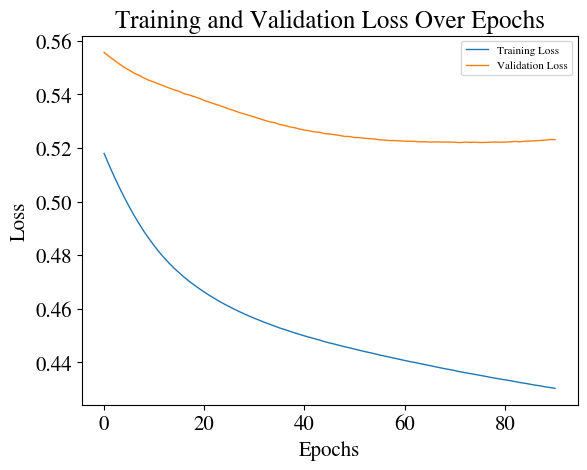

In [21]:

plt.plot(training_params.loss_array[:, 0], training_params.loss_array[:, 1], label="Training Loss")
plt.plot(training_params.loss_array[:, 0], training_params.loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


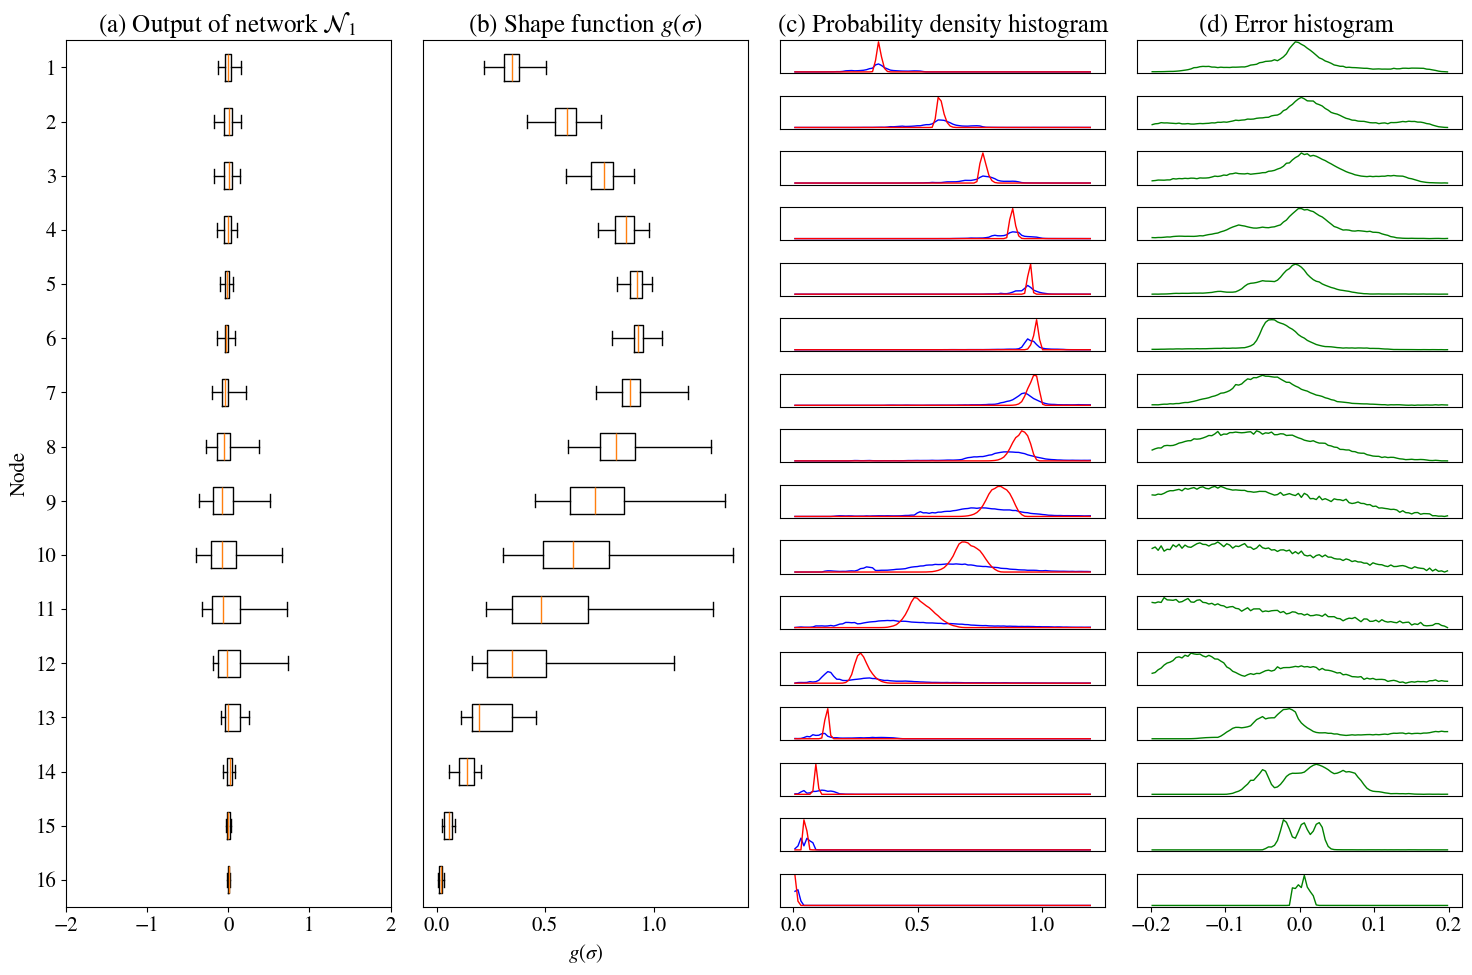

In [22]:
ff_pca.performance_sigma_point(
    model=training_params.model,
    x=x, 
    valid_x=valid_x,
    y=y,
    valid_y=valid_y,
    train_data_obj=train_data_obj)

# 4. Sparse Gaussian Process Regression (GPR)

The Sparse Gaussian Process Regression (SGPR) implemented in this notebook represents a sophisticated enhancement to the neural network model for vertical ocean diffusivity prediction. This approach combines the strengths of deep learning (neural networks) with Bayesian probabilistic modeling (Gaussian processes) to create a hybrid model that offers both improved accuracy and uncertainty quantification. The key innovation is using a Sparse Gaussian Process (SGP) on top of the neural network’s penultimate layer features. The sparsity is implemented through inducing points, which are a subset of training points that serve as a compact summary of the full dataset.

## 4.1 Preprocessing and validation dataset

This is the same as the original Sane et al. notebook, but differs slightly from the above PCA validation dataset so we reset it here.

In [17]:
data, x,y, stats, k_mean, k_std=ff_og.preprocess_train_data(data_load_gpr)  

In [18]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

## 4.2 Neural Network Architecture

In [20]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)
        self.linear2 = nn.Linear(Hid, Hid)
        self.linear3 = nn.Linear(Hid, Out_nodes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)
        h1 = self.dropout(h1)

        h2 = self.linear2(h1)
        h3 = torch.relu(h2)
        h3 = self.dropout(h3)

        y_pred = self.linear3(h3)
        return y_pred

    def penultimate(self, x):
        """
        This method returns the hidden (penultimate) layer
        output before the final linear layer.
        """
        x2 = self.linear1(x)
        h1 = torch.relu(x2)
        h1 = self.dropout(h1)

        h2 = self.linear2(h1)
        h3 = torch.relu(h2)
        h3 = self.dropout(h3)

        # we do NOT apply the final linear3 here
        return h3


## 4.4 Base model training
The modeltrain_loss function trains a neural network model using PyTorch with a custom loss calculation and implements early stopping to prevent overfitting and save computing time.

Early Stopping: Stops training if the validation loss does not improve for patience consecutive epochs, saving the best model state. Increasing patience will further reduce loss, but lengthen runtime.

In [21]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [22]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

# Train N1 for the first time!
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:  20%|██        | 610/3000 [04:54<19:13,  2.07epoch/s, patience_count=19, train_loss=0.0398, valid_loss=0.0569]


Early stopping at epoch 610. Validation loss has not improved for 20 epochs.


## 4.5 Sparse GPR training

Each vertical level is treated as a separate regression problem, allowing the model to capture depth-dependent ocean processes. The data is converted to float tensors and moved to the device (GPU/CPU). A sparse approximation is used by selecting 200 random inducing points, striking a balance between accuracy and computational efficiency. Variational inference approximates the posterior by minimizing the ELBO with the Adam optimizer (learning rate 0.01) for 300 epochs, learning kernel hyperparameters, noise variance, and inducing point locations. A Cholesky-based variational distribution ensures numerical stability. The model uses a zero-mean function and a scaled RBF kernel (for smoothness), and a separate GP is trained for each depth level.

In [23]:
model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)

In [24]:
import gpytorch

model.eval()  # set NN to eval mode
with torch.no_grad():
    # penultimate features for the *training* set
    X_train_hid_torch = model.penultimate(x)  # shape [N, Hid]
    # Move them to CPU if needed
    X_train_hid_torch = X_train_hid_torch.cpu()
    
    # Suppose y is shape [N,16], i.e. we have 16 vertical levels
    Y_train_torch = y.cpu()  # shape [N,16]

In [25]:
class SparseGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
num_levels = 16
gp_models = []
likelihoods = []

for i in range(num_levels):
    print(f"Training GP for level {i} ...")
    
    # 1) Extract target for this level
    Y_train_level = Y_train_torch[:, i]  # shape [N]
    
    # 2) Convert to float if needed
    X_train_hid_torch = X_train_hid_torch.float()
    Y_train_level = Y_train_level.float()
    
    # 3) Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_hid_torch = X_train_hid_torch.to(device)
    Y_train_level = Y_train_level.to(device)
    
    # 4) Define the GP model and likelihood
    # e.g. pick M = 200 random inducing points for a sparse GP
    M = 200
    idx_inducing = np.random.choice(X_train_hid_torch.shape[0], M, replace=False)
    inducing_points = X_train_hid_torch[idx_inducing, :]
    
    model_gp = SparseGPRegressionModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    
    # 5) Train using a Variational ELBO
    optimizer = torch.optim.Adam(
        list(model_gp.parameters()) + list(likelihood.parameters()),
        lr=0.01
    )
    mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp, num_data=X_train_hid_torch.size(0))
    
    model_gp.train()
    likelihood.train()
    epochs_gp = 300
    
    for epoch in range(epochs_gp):
        optimizer.zero_grad()
        output = model_gp(X_train_hid_torch)
        loss = -mll(output, Y_train_level)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f"  Level {i}, Epoch {epoch + 1}/{epochs_gp}, Loss = {loss.item():.3f}")
    
    # 6) Store the trained model and likelihood in lists
    gp_models.append(model_gp)
    likelihoods.append(likelihood)


## 4.6 Evaluation and visualization

In [46]:
results = compare_models(model, gp_models, likelihoods, valid_x, valid_y, k_mean, k_std)

### 4.6.1 Overall performance metrics comparison

This plot compares the overall performance metrics between your neural network (NN) and NN+GP models. The blue bars represent the error of the neural network alone, while the orange bars show the error after adding the Gaussian Process (GP) layer. The significant difference between the bars demonstrates that adding the GP layer substantially improves both mean absolute error (MAE) and root mean square error (RMSE). In this case, the GP enhancement has reduced MAE by approximately 60-65% and RMSE by about 50-55%, showing a dramatic improvement in prediction accuracy.

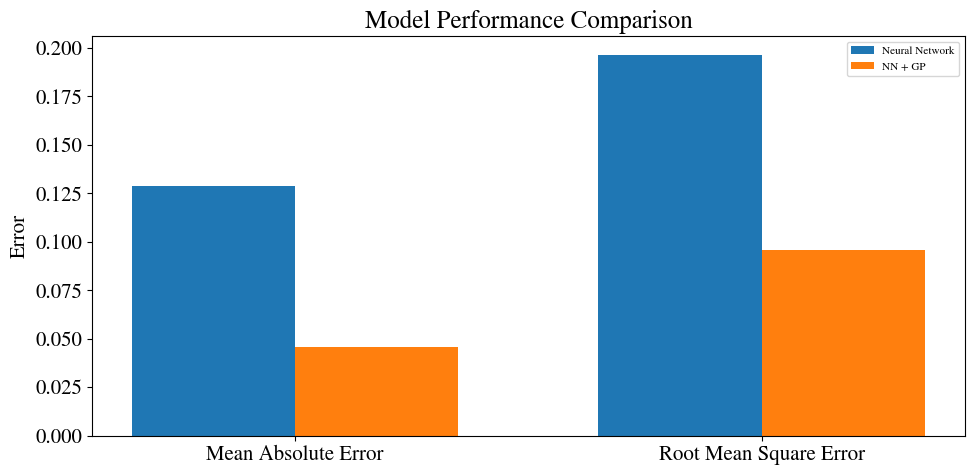

MAE Improvement: 64.67%
RMSE Improvement: 51.15%


In [48]:
plot_performance_metrics(results)

### 4.6.2 Error by vertical node

This horizontal bar chart shows the error distribution across different vertical levels in the ocean model. The visualization reveals that: The NN+GP model (brown bars) consistently produces lower errors than the original NN (blue bars) across all levels The middle levels (9-12) have the highest overall error in both models The GP enhancement provides the greatest improvement in mid-to-upper levels The near-surface (levels 15-16) and near-bottom (levels 1-2) regions have relatively low errors in both models

This pattern suggests that the diffusivity field is more complex and harder to predict in the middle of the boundary layer, and the GP is particularly helpful for capturing this complexity.

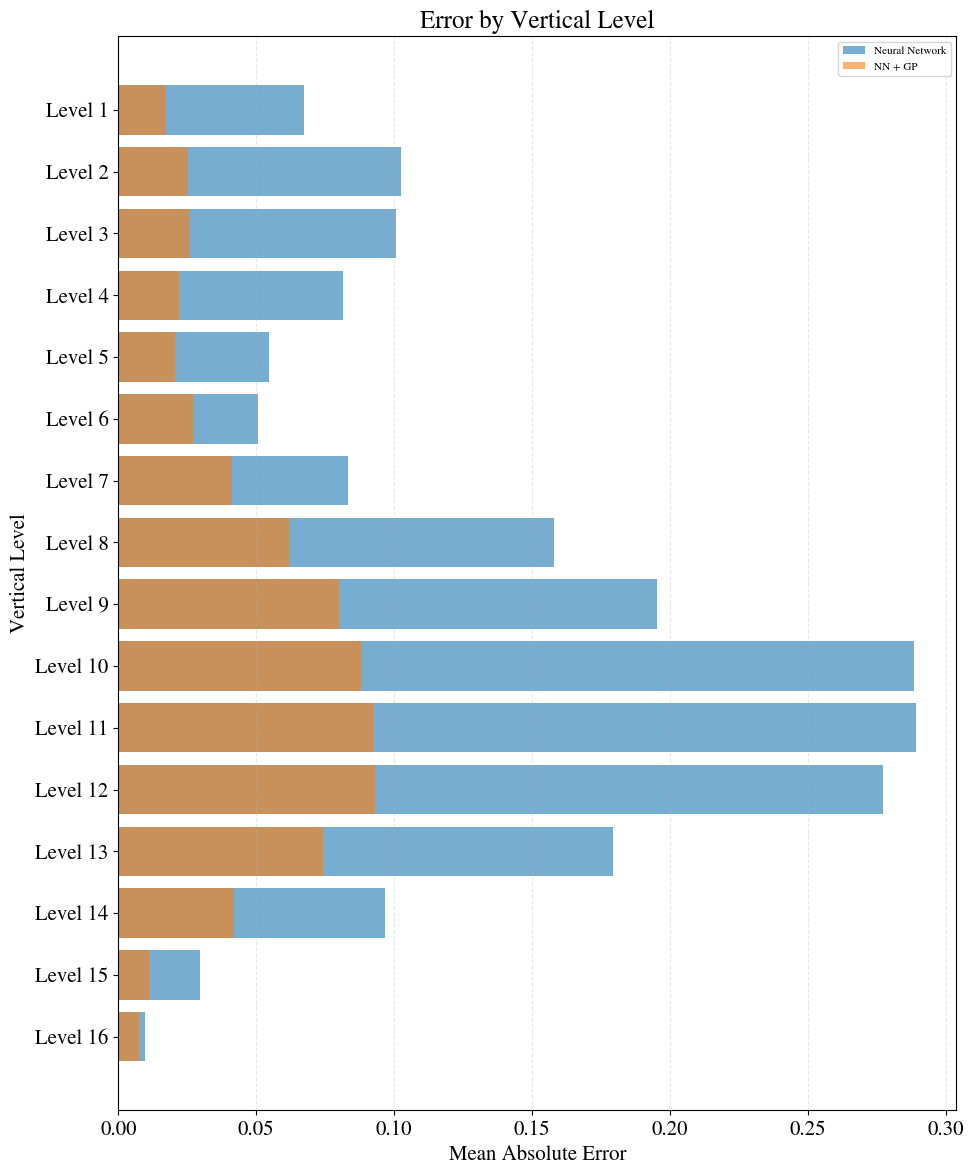

Level with greatest improvement: Level 2 (75.17%)
Level with least improvement: Level 16 (24.39%)


In [54]:
plot_error_by_level(results)

### 4.6.3 Sample Profile Predictions with Uncertainty

These plots show four randomly selected vertical profiles from the validation dataset.

Black line: True diffusivity values Blue line: Predictions from the neural network Red line: Predictions from the NN+GP model Red shaded area: 95% confidence interval from the GP model

The NN+GP model (red line) typically follows the true values (black line) more closely than the NN alone (blue line) The confidence intervals provided by the GP capture the uncertainty in predictions, with wider bands in regions of higher uncertainty The original NN tends to produce a more step-like (discretized) profile, while the GP creates smoother, more physically realistic transitions The uncertainty is generally higher in the middle layers, which is consistent with the error pattern seen in the previous plot

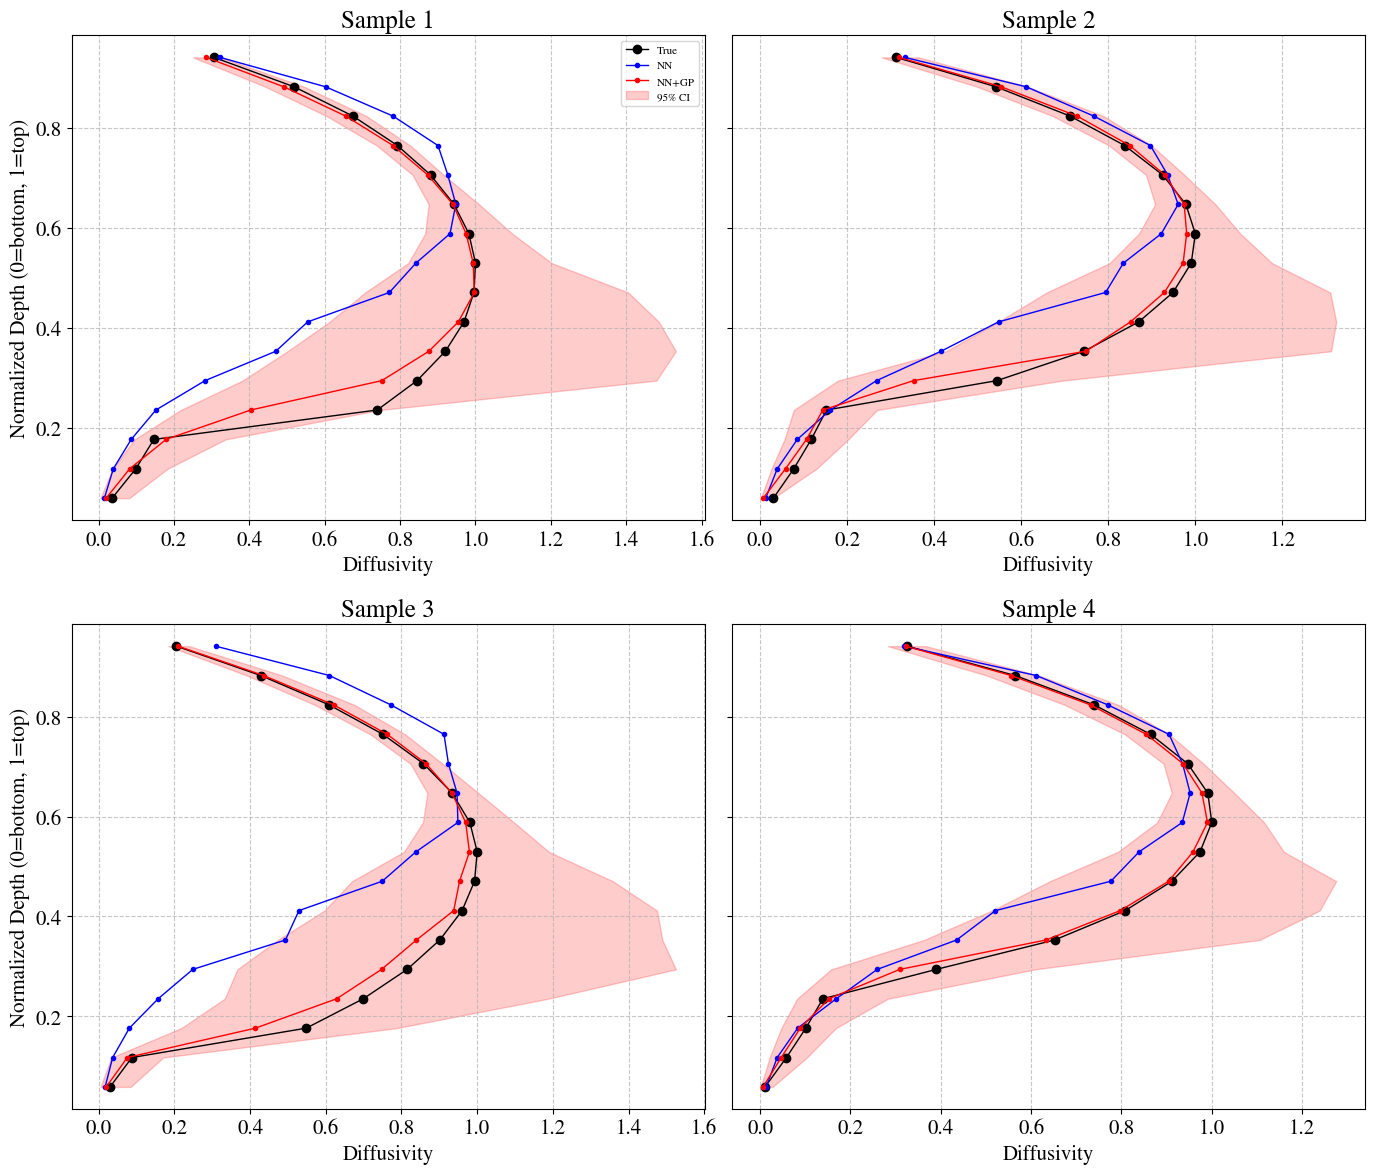

True values fall within 95% confidence intervals 88.18% of the time


In [56]:
plot_sample_profiles(results)

### 4.6.4 Parity Plots (Predicted vs Actual)

These parity plots show predicted values vs. true values for both models. The stark contrast between these plots reveals the most significant improvement from adding the GP layer:

Neural Network (left): The plot shows distinct horizontal banding, indicating that the NN is “quantizing” the diffusivity field into discrete values. This suggests the NN has learned to predict only a limited set of values rather than a continuous range, resulting in a stepped prediction pattern that doesn’t capture the full variability of ocean diffusivity. NN+GP (right): The predictions now follow a much more continuous distribution that closely aligns with the diagonal line. The GP layer has effectively “smoothed out” the discrete predictions of the NN, producing a much more physically realistic representation of the diffusivity field.

This transformation from discrete to continuous prediction space is critical for ocean modeling, as it better represents the physical reality of diffusion processes in the ocean boundary layer.

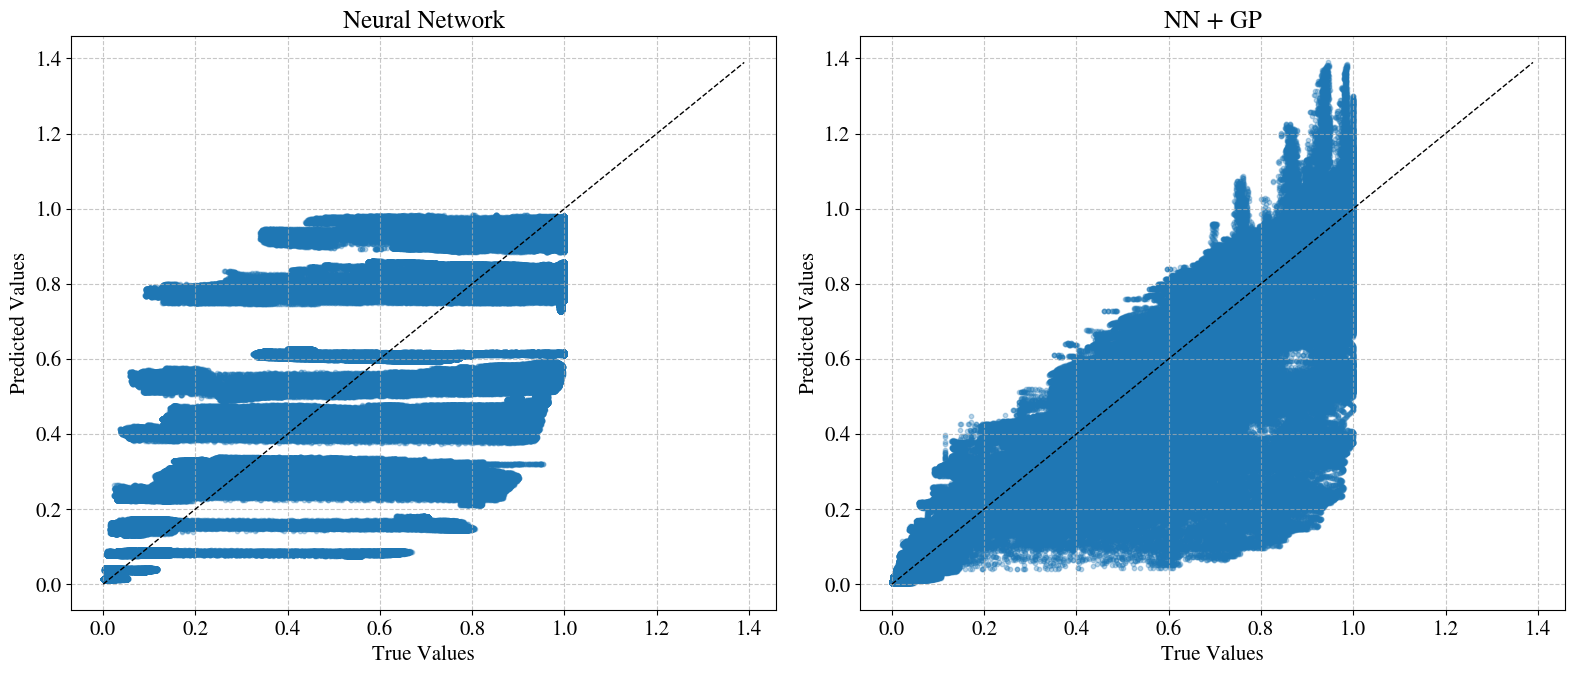

Neural Network R²: 0.7069
NN+GP R²: 0.9301
R² Improvement: 0.2232


In [57]:
plot_parity_comparison(results)

### 4.6.5 Uncertainty Distribution by Vertical Level

This violin plot shows the distribution of uncertainty (measured as the width of the 95% confidence interval) at each vertical level in the ocean model. Key insights from this visualization:

Uncertainty is highest in the middle layers (particularly levels 10-12), which aligns with where the model has the highest error The near-surface (levels 15-16) and near-bottom (levels 1-2) show consistently lower uncertainty The distribution shapes vary significantly between levels, with some showing wide variability in uncertainty across different conditions The pattern suggests that the diffusivity field is most difficult to predict (and thus most uncertain) in the middle of the boundary layer

This uncertainty quantification is a major advantage of the GP approach, as it provides valuable information about prediction reliability that isn’t available from the standard neural network. Areas with higher uncertainty might warrant additional attention or data collection in future modeling efforts.

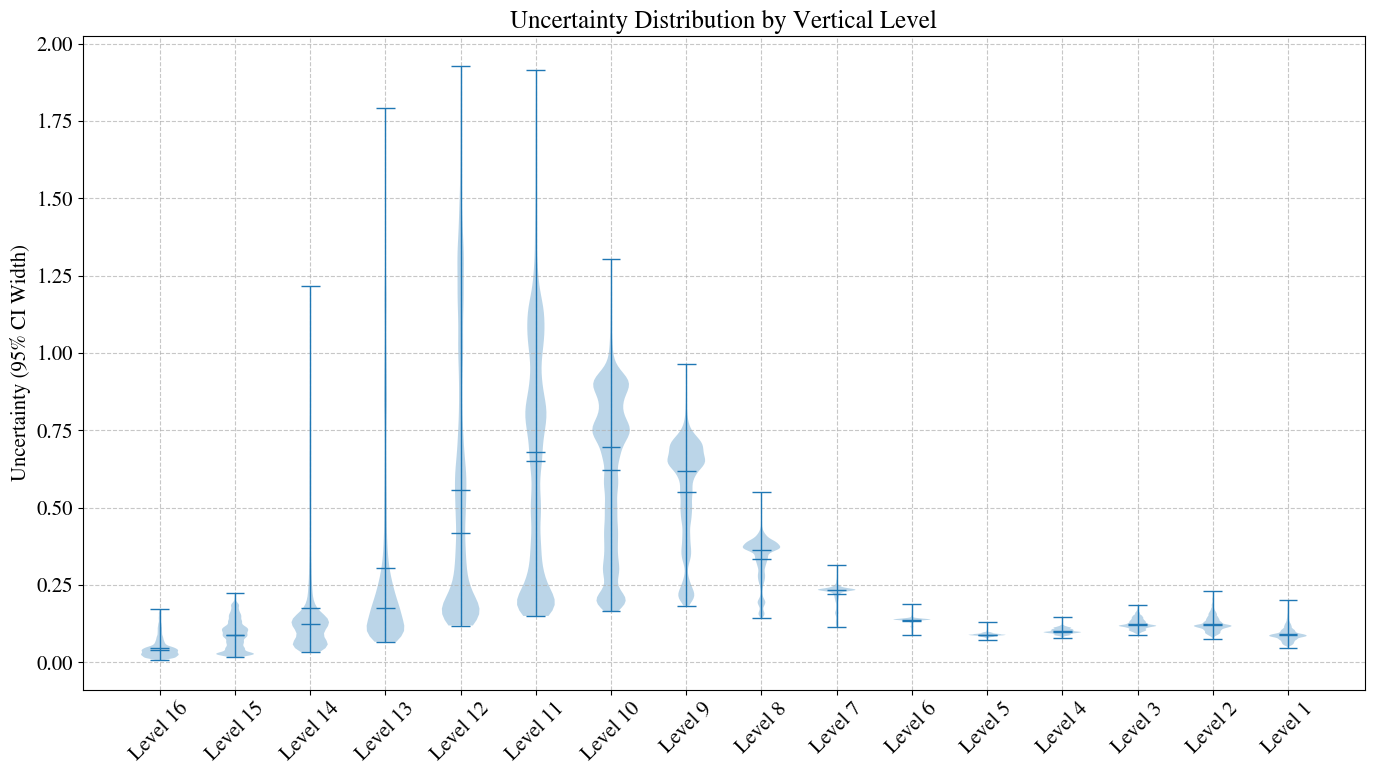

Level with highest uncertainty: Level 11 (mean width: 0.6520)
Level with lowest uncertainty: Level 16 (mean width: 0.0473)
Correlation between depth and uncertainty: -0.2103


In [58]:
plot_uncertainty_distribution(results)

### 4.6.6 Uncertainty vs. Error Relationship

This scatter plot examines the relationship between the model’s uncertainty estimates and actual prediction errors. Each point represents a single prediction, with the x-axis showing the width of the confidence interval (uncertainty) and the y-axis showing the absolute error of that prediction. From the plot, we can observe:

There’s a positive but weak correlation (r ≈ 0.22) between uncertainty and error, meaning predictions with higher uncertainty tend to have somewhat higher errors The relationship is not very strong, indicating that while the uncertainty estimates provide useful information, they’re not perfect predictors of error There are many points with low uncertainty but relatively high error, suggesting some overconfident predictions The distinct patterns in the scatter plot (the linear structures) likely correspond to different vertical levels or specific ocean conditions

A well-calibrated uncertainty model should show a stronger positive correlation between estimated uncertainty and actual error. The moderate correlation observed suggests the GP uncertainty estimates are informative but could potentially be improved with further model refinement.

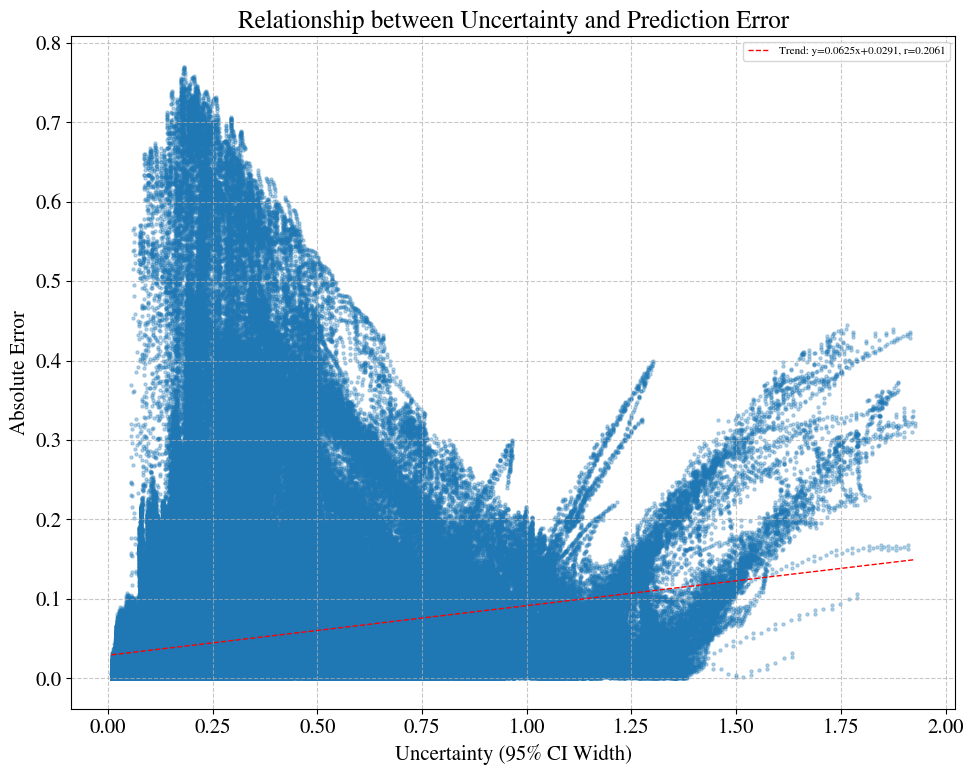

Correlation between uncertainty and error: 0.2061 (p-value: 0.0000e+00)
Overall, 88.18% of true values fall within the 95% confidence intervals
Level 16: 95.92% coverage
Level 15: 90.92% coverage
Level 14: 85.28% coverage
Level 13: 86.71% coverage
Level 12: 92.56% coverage
Level 11: 86.82% coverage
Level 10: 84.00% coverage
Level 9: 85.71% coverage
Level 8: 83.94% coverage
Level 7: 85.79% coverage
Level 6: 87.08% coverage
Level 5: 85.58% coverage
Level 4: 88.73% coverage
Level 3: 89.53% coverage
Level 2: 90.53% coverage
Level 1: 91.75% coverage


In [59]:
plot_uncertainty_vs_error(results)

## 4.7 Sparse GPR Advantages

#### Computational Efficiency
By using M=200 inducing points instead of the full dataset (which may contain thousands of points), the model achieves:
* Reduced memory requirements
* Faster training and inference
* Ability to scale to larger datasets

#### Uncertainty Quantification
Unlike the deterministic neural network, the GP layer provides a principled way to estimate uncertainty in predictions, which is particularly valuable for:

* Identifying regions where the model is less confident
* Guiding future data collection efforts
* Supporting risk-aware decision making in oceanographic applications

#### Inductive Bias for Smoothness
The GP's inherent smoothness bias helps transform the discrete, banded predictions of the neural network into physically plausible continuous fields, better representing the underlying diffusion processes.

#### Transfer Learning Potential
The feature extraction capabilities of the neural network combined with the flexible modeling of the GP layer offers potential for transfer learning to related oceanographic prediction tasks.

#### Future Enhancements

* Multi-output GPs: Implementing a true multi-output GP that captures correlations between vertical levels could further improve accuracy.
* Custom Kernels: Developing physics-informed kernels that incorporate known oceanographic constraints.
* End-to-end Training: Joint optimization of both the neural network feature extractor and the GP layer.
* Temporal Dynamics: Extending the model to capture temporal evolution of diffusivity fields.

# 5. Gaussian Features

Vertical mixing in the ocean surface boundary layer (OSBL) is often parameterized using a fixed *“universal”* shape function for the vertical diffusivity profile. However, Second Moment Closure models show that the actual shape of the diffusivity profile can vary significantly with forcing conditions. 

We seek to use neural networks to predict these variable shape functions, building on the work of Sane et al. (2023). In particular, we implement two modeling strategies using PyTorch:

---

### 1. **Direct shape prediction with Gaussian feature layer**
- Transform the input physical parameters through a Gaussian radial-basis function (RBF) layer
- Have the network output the 16 discrete values of the shape function profile directly (at fixed vertical levels)

---

### 2. **Gaussian Mixture Model (GMM) output**
- Have the network predict parameters of a Gaussian mixture (means, standard deviations, amplitudes)
- Reconstruct the shape function as a sum of Gaussians over the vertical coordinate

---

### Inputs and Training Details

Both models use the following inputs (consistent with Sane et al., 2023):
- Coriolis parameter *f*
- Surface buoyancy flux *B₀*
- Friction velocity *uₐ*
- Boundary layer depth *h*

To ensure predicted diffusivity profiles remain non-negative, we predict the **logarithm** of the shape function, `log g(σ)`, rather than `g(σ)` itself.

We train the networks on data generated by a high-resolution 1-D turbulence model (e.g., GOTM in Sane et al., 2023) that provides “SMC-based” shape functions.

---

### Loss and Regularization
- Model training uses **mean absolute error (L1 loss)**, which outperformed L2 (RMSE) for this problem.
- We also employ **early stopping** based on validation loss to prevent overfitting.

## 5.1 Data

In [32]:
import numpy as np
import xarray as xr

# Open the dataset from Sane et al. 2023, stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'

# Load the dataset
ds = xr.open_dataset(store, engine='zarr')


X = np.column_stack([
    ds['b0'].values,   
    ds['h'].values,    
    ds['ustar'].values,
    ds['lat'].values   
])


y = ds['SF'].values

N_total = len(X)
N_train = int(0.6 * N_total)
N_val = int(0.2 * N_total)
N_test = N_total - N_train - N_val

X_train = X[:N_train]
X_val = X[N_train:N_train+N_val]
X_test = X[N_train+N_val:]

y_train = y[:N_train]
y_val = y[N_train:N_train+N_val]
y_test = y[N_train+N_val:]

y_train_log = np.log(np.maximum(y_train, 1e-10))  # 避免log(0)
mean_log = y_train_log.mean(axis=0)
std_log = y_train_log.std(axis=0)
y_train_norm = (y_train_log - mean_log) / std_log

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std

X_val_norm = (X_val - X_mean) / X_std
y_val_log = np.log(np.maximum(y_val, 1e-10))
y_val_norm = (y_val_log - mean_log) / std_log

X_test_norm = (X_test - X_mean) / X_std
y_test_log = np.log(np.maximum(y_test, 1e-10))
y_test_norm = (y_test_log - mean_log) / std_log

## 5.2 RBF Neural Network (Gaussian Features)


**Architecture:**  
The first model uses a radial basis function (RBF) layer to transform the input features into a higher-dimensional feature space before prediction.

An RBF layer consists of a set of Gaussian “basis” functions:  

$$
\phi_i = \exp\left(-\frac{||x - \mu_i||^2}{2\sigma_i^2}\right)
$$

where:  
- $\mu_i$ is the center of the *i*-th Gaussian in input space  
- $\sigma_i$ is its width  

By using RBF features, the network can more easily capture nonlinear interactions between the inputs in a smooth way.  
We then use a linear layer to map these RBF features to the 16 outputs (corresponding to $\log g$ at the 16 depth points).

---

**Implementation details:**  
- We choose a certain number of RBF centers (e.g., 50) and initialize their centers ($\mu_i$) using representative points from the training data (e.g., via clustering or random sampling).  
- We fix the RBF widths $\sigma_i$ (or treat them as learnable parameters).  
- For simplicity, we use **isotropic Gaussians** with either a constant width or one width per center.  
- The output layer is **linear** (no activation), because we want it to produce **real values** (which correspond to normalized log-shape values).

In [33]:
class RBFShapeNet(nn.Module):
    def __init__(self, input_dim, num_centers, output_dim, centers, widths):
        super().__init__()
        # Register the RBF centers and widths as buffers (non-trainable tensors)
        self.register_buffer('centers', torch.tensor(centers, dtype=torch.float32))
        self.register_buffer('widths',  torch.tensor(widths, dtype=torch.float32))
        # Linear layer to map RBF features to 16 outputs (log(g) values)
        self.out_layer = nn.Linear(num_centers, output_dim)
    
    def forward(self, x):
        # x: shape (batch_size, input_dim), normalized inputs
        # Compute squared distance of x to each center (broadcasting)
        # centers: (num_centers, input_dim)
        diff = x.unsqueeze(1) - self.centers.unsqueeze(0)   # (batch, num_centers, input_dim)
        dist_sq = torch.sum(diff**2, dim=-1)                # (batch, num_centers)
        # Compute RBF activations: exp(-dist^2 / (2σ^2))
        phi = torch.exp(-dist_sq / (2 * (self.widths**2)))
        # Linear combination of RBF features to get outputs
        out = self.out_layer(phi)  # (batch, 16)
        return out

# Initialize RBF centers and widths (e.g., using 50 random training samples as centers)
num_centers = 50
idx = np.random.choice(len(X_train_norm), num_centers, replace=False)
centers_init = X_train_norm[idx]                 # shape (50, 4)
widths_init = np.full(num_centers, 1.0)          # e.g. use width=1.0 for all, or tune as needed

# Instantiate the model
input_dim = X_train_norm.shape[1]   # 4
output_dim = y_train_norm.shape[1]  # 16
model_rbf = RBFShapeNet(input_dim, num_centers, output_dim, centers_init, widths_init)
print(model_rbf)

RBFShapeNet(
  (out_layer): Linear(in_features=50, out_features=16, bias=True)
)


## 5.3 Gaussian Mixture Network

**Architecture:**  
The second model outputs a *parameterized functional representation* of the shape profile instead of predicting each value independently.

Specifically, the network will output the parameters of a Gaussian Mixture Model (GMM): a set of $K$ Gaussian components whose sum defines the shape function.

For example, with $K = 3$, the network will output:
- 3 means: $\mu_1$, $\mu_2$, $\mu_3$  
- 3 standard deviations: $\sigma_1$, $\sigma_2$, $\sigma_3$  
- 3 amplitudes: $A_1$, $A_2$, $A_3$  

The shape function is then reconstructed as:

$$
g(\sigma) = \sum_{k=1}^{K} A_k \exp\left( -\frac{(\sigma - \mu_k)^2}{2\sigma_k^2} \right)
$$

for $\sigma \in [0, 1]$ (the normalized depth).  

This ensures $g(\sigma)$ is always **positive** (since each Gaussian component is positive) and **smooth**.

By adjusting the Gaussian parameters, the network can represent a variety of profile shapes with a relatively small number of parameters  
(e.g., 9 parameters for 3 Gaussians, instead of 16 independent values).  

This approach adds physical structure to the output and can improve generalization by restricting outputs to plausible smooth shapes.

---

**Implementation details:**  
- We use a standard feed-forward network to map the inputs to the Gaussian parameters.  
- The output layer has $3K$ units, which we split into means, standard deviations, and amplitudes.  
- We apply appropriate **activations** to enforce constraints:
  - A **sigmoid** to map raw mean outputs to $(0,1)$ (since $\sigma$ is normalized depth),
  - A **softplus** to ensure standard deviations are positive,
  - A **softplus** for amplitudes (to ensure positivity).  
- We then reconstruct the shape profile at the 16 discrete $\sigma$ points.  
- During training, we compare this reconstructed (log) profile to the target profile.

In [34]:
class GMMShapeNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_components):
        super().__init__()
        self.num_components = num_components
        # Two hidden layers (fully connected)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer: predicts 3 * num_components parameters
        self.fc_out = nn.Linear(hidden_dim, 3 * num_components)
    
    def forward(self, x):
        # x: (batch_size, input_dim) normalized inputs
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        params = self.fc_out(h)  # shape (batch, 3*K)
        K = self.num_components
        mean_raw = params[:, 0:K]
        std_raw  = params[:, K:2*K]
        amp_raw  = params[:, 2*K:3*K]
        
        # Apply constraints
        means = torch.sigmoid(mean_raw)        # in (0,1)
        stds  = F.softplus(std_raw) + 1e-6      # >0
        amps  = F.softplus(amp_raw)             # >0
        
        # Sigma points as tensor (assumes global variable sigma_points exists)
        sigma = torch.tensor(sigma_points, dtype=torch.float32, device=x.device)
        
        # Compute Gaussians
        diff = sigma.unsqueeze(0).unsqueeze(0) - means.unsqueeze(2)  # (batch, K, 16)
        gauss = torch.exp(-0.5 * (diff / stds.unsqueeze(2)) ** 2)    # (batch, K, 16)
        weighted = amps.unsqueeze(2) * gauss                         # (batch, K, 16)
        g_sigma = torch.sum(weighted, dim=1)                         # (batch, 16)
        
        # Log and normalize
        log_g = torch.log(g_sigma + 1e-10)
        log_g_norm = (log_g - torch.tensor(mean_log, device=x.device)) / torch.tensor(std_log, device=x.device)
        return log_g_norm

model_gmm = GMMShapeNet(input_dim=4, hidden_dim=64, num_components=3)
print(model_gmm)

GMMShapeNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=9, bias=True)
)


## 5.4 Model training

We train both models to minimize the L1 loss between the predicted and true log-shape profiles.
We use early stopping on a validation set to avoid overfitting.

Early stopping will monitor the validation loss and stop training if it hasn’t improved for a certain number of epochs (patience).
We also save the model weights corresponding to the best validation loss.

In [36]:
class GMMShapeNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_components, sigma_points=None):
        super().__init__()
        self.num_components = num_components
        
        # If sigma_points is not provided, create default
        if sigma_points is None:
            sigma_points = np.linspace(0, 1, 18)[1:-1]
        
        # Register sigma_points as a buffer
        self.register_buffer('sigma_points', torch.tensor(sigma_points, dtype=torch.float32))
        
        # Two hidden layers (fully connected)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer: predicts 3 * num_components parameters
        self.fc_out = nn.Linear(hidden_dim, 3 * num_components)
    
    def forward(self, x):
        # x: (batch_size, input_dim) normalized inputs
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        params = self.fc_out(h)  # shape (batch, 3*K)
        K = self.num_components
        mean_raw = params[:, 0:K]
        std_raw  = params[:, K:2*K]
        amp_raw  = params[:, 2*K:3*K]
        
        # Apply constraints
        means = torch.sigmoid(mean_raw)        # in (0,1)
        stds  = F.softplus(std_raw) + 1e-6     # >0
        amps  = F.softplus(amp_raw)            # >0
        
        # Use registered sigma points
        sigma = self.sigma_points
        
        # Compute Gaussians
        diff = sigma.unsqueeze(0).unsqueeze(0) - means.unsqueeze(2)  # (batch, K, 16)
        gauss = torch.exp(-0.5 * (diff / stds.unsqueeze(2)) ** 2)    # (batch, K, 16)
        weighted = amps.unsqueeze(2) * gauss                         # (batch, K, 16)
        g_sigma = torch.sum(weighted, dim=1)                         # (batch, 16)
        
        # Log and normalize
        log_g = torch.log(g_sigma + 1e-10)
        
        # Assuming mean_log and std_log are available globally
        log_g_norm = (log_g - torch.tensor(mean_log, device=x.device)) / torch.tensor(std_log, device=x.device)
        return log_g_norm

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()  # L1 loss (MAE) on normalized log(g)
    
    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        # Shuffle training data indices
        perm = torch.randperm(X_train_t.size(0))
        batch_losses = []
        
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            x_batch = X_train_t[idx]
            y_batch = y_train_t[idx]
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # Compute average training loss for this epoch
        train_loss = np.mean(batch_losses)
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t).item()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()  # save best model parameters
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
            break
    
    # Load best model weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# Create models
model_rbf = RBFShapeNet(input_dim=X_train_norm.shape[1], 
                        num_centers=50, 
                        output_dim=y_train_norm.shape[1], 
                        centers=centers_init, 
                        widths=widths_init)

model_gmm = GMMShapeNet(input_dim=X_train_norm.shape[1], 
                        hidden_dim=64, 
                        num_components=3)


In [ ]:
model_rbf = train_model(model_rbf, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100, patience=10)
model_gmm = train_model(model_gmm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100, patience=10)

Epoch 10: Train loss=0.2544, Val loss=0.4130
Epoch 20: Train loss=0.2532, Val loss=0.4114
Epoch 30: Train loss=0.2524, Val loss=0.4075
Epoch 40: Train loss=0.2517, Val loss=0.4069
Epoch 50: Train loss=0.2512, Val loss=0.4049
Epoch 60: Train loss=0.2508, Val loss=0.4019
Epoch 70: Train loss=0.2505, Val loss=0.4007
Early stopping at epoch 73 (no improvement in 10 epochs).
Epoch 10: Train loss=0.1364, Val loss=0.1006


## 5.5 Model evaluation

In [ ]:
model_rbf.eval()
with torch.no_grad():
    pred_test_rbf = model_rbf(torch.tensor(X_test_norm, dtype=torch.float32)).cpu().numpy()
model_gmm.eval()
with torch.no_grad():
    pred_test_gmm = model_gmm(torch.tensor(X_test_norm, dtype=torch.float32)).cpu().numpy()

# Invert normalization for evaluation (to get actual log(g) values)
pred_log_rbf = pred_test_rbf * std_log + mean_log
pred_log_gmm = pred_test_gmm * std_log + mean_log
y_test_log   = np.log(y_test)  # true log(g) on test
# Convert log back to g(sigma) for intuition (though metrics can be on log scale too)
pred_g_rbf = np.exp(pred_log_rbf)
pred_g_gmm = np.exp(pred_log_gmm)
true_g     = y_test

# Compute MAE and RMSE in physical space
mae_rbf  = np.mean(np.abs(pred_g_rbf - true_g))
rmse_rbf = np.sqrt(np.mean((pred_g_rbf - true_g)**2))
mae_gmm  = np.mean(np.abs(pred_g_gmm - true_g))
rmse_gmm = np.sqrt(np.mean((pred_g_gmm - true_g)**2))
print(f"RBF Model – MAE: {mae_rbf:.4f}, RMSE: {rmse_rbf:.4f}")
print(f"GMM Model – MAE: {mae_gmm:.4f}, RMSE: {rmse_gmm:.4f}")

# Compute weighted-average correlation
def weighted_correlation(pred_profiles, true_profiles):
    # pred_profiles, true_profiles: arrays of shape (n_samples, 16)
    correlations = []
    weights = []
    for j in range(true_profiles.shape[1]):  # for each depth level
        pj = pred_profiles[:, j]
        tj = true_profiles[:, j]
        # Pearson correlation at level j
        corr = np.corrcoef(pj, tj)[0,1]
        correlations.append(corr)
        weights.append(np.mean(true_profiles[:, j]))  # weight by mean true g at this level
    correlations = np.array(correlations)
    weights = np.array(weights)
    # Weighted average
    return np.sum(correlations * weights) / np.sum(weights)

wcorr_rbf = weighted_correlation(pred_g_rbf, true_g)
wcorr_gmm = weighted_correlation(pred_g_gmm, true_g)
print(f"Weighted correlation – RBF: {wcorr_rbf:.3f}, GMM: {wcorr_gmm:.3f}")

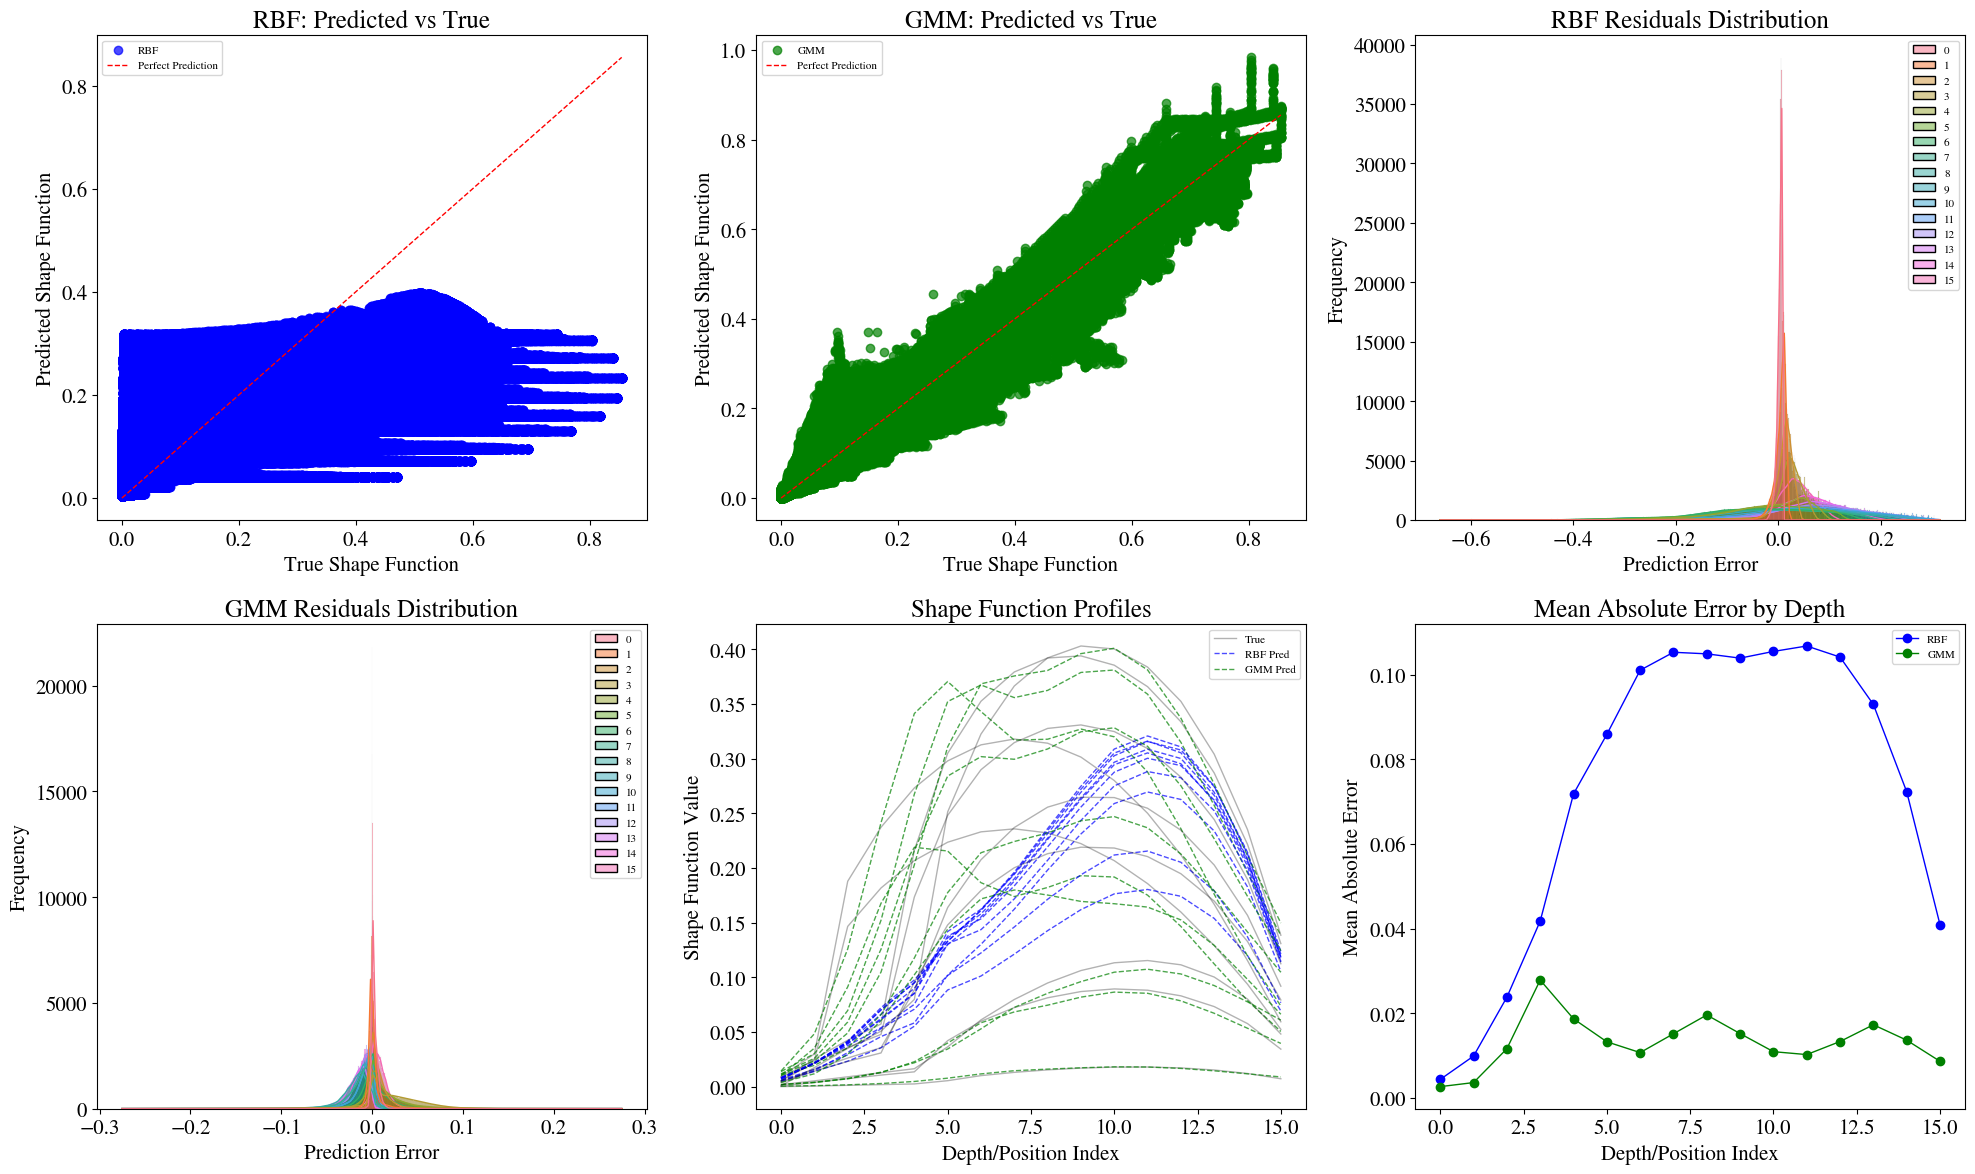

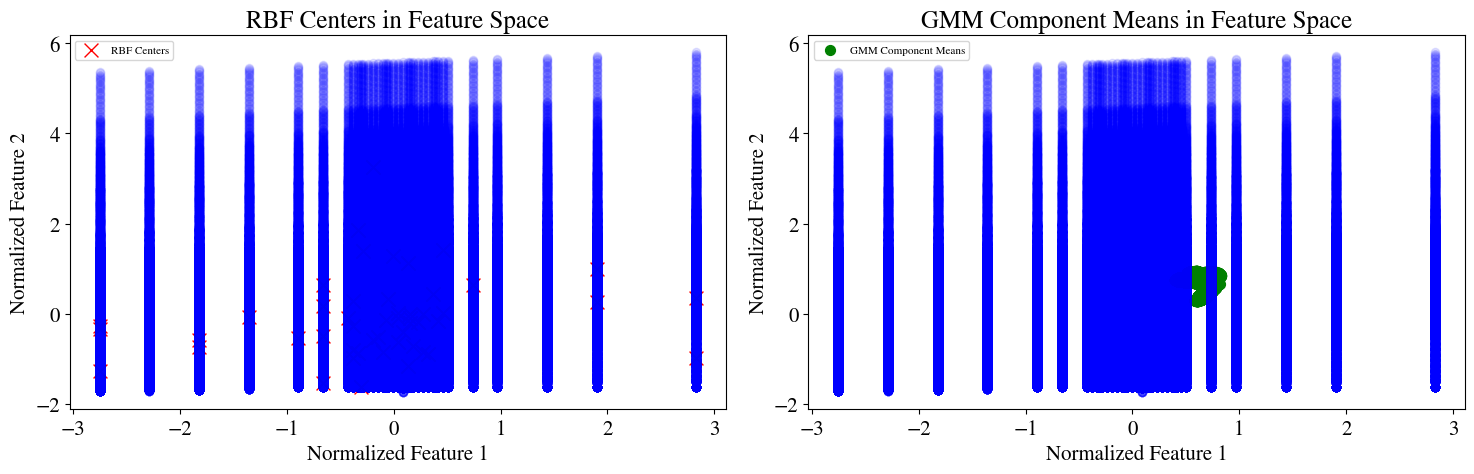

In [ ]:
def visualize_model_performance(X_test_norm, y_test, pred_g_rbf, pred_g_gmm, 
                                mean_log, std_log, title_prefix=''):
    """
    Comprehensive visualization of RBF and GMM model predictions
    
    Parameters:
    - X_test_norm: Normalized test input features
    - y_test: True shape function values
    - pred_g_rbf: RBF model predictions
    - pred_g_gmm: GMM model predictions
    - mean_log: Mean of log-transformed training data
    - std_log: Standard deviation of log-transformed training data
    - title_prefix: Optional prefix for plot titles
    """
    plt.figure(figsize=(20, 12))
    
    # 1. Scatter plot of predicted vs true values for both models
    plt.subplot(2, 3, 1)
    plt.scatter(y_test, pred_g_rbf, label='RBF', alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
    plt.title(f'{title_prefix}RBF: Predicted vs True')
    plt.xlabel('True Shape Function')
    plt.ylabel('Predicted Shape Function')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.scatter(y_test, pred_g_gmm, label='GMM', alpha=0.7, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
    plt.title(f'{title_prefix}GMM: Predicted vs True')
    plt.xlabel('True Shape Function')
    plt.ylabel('Predicted Shape Function')
    plt.legend()
    
    # 2. Residual plots
    plt.subplot(2, 3, 3)
    residuals_rbf = pred_g_rbf - y_test
    sns.histplot(residuals_rbf, kde=True, color='blue')
    plt.title(f'{title_prefix}RBF Residuals Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

    plt.subplot(2, 3, 4)
    residuals_gmm = pred_g_gmm - y_test
    sns.histplot(residuals_gmm, kde=True, color='green')
    plt.title(f'{title_prefix}GMM Residuals Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    
    # 3. Profile Comparison
    plt.subplot(2, 3, 5)
    # Random selection of 10 samples to show profile comparison
    indices = np.random.choice(len(y_test), 10, replace=False)
    for idx in indices:
        plt.plot(range(len(y_test[idx])), y_test[idx], 'k-', alpha=0.3)
        plt.plot(range(len(y_test[idx])), pred_g_rbf[idx], 'b--', alpha=0.7)
        plt.plot(range(len(y_test[idx])), pred_g_gmm[idx], 'g--', alpha=0.7)
    plt.title(f'{title_prefix}Shape Function Profiles')
    plt.xlabel('Depth/Position Index')
    plt.ylabel('Shape Function Value')
    plt.legend(['True', 'RBF Pred', 'GMM Pred'])
    
    # 4. Depth-wise Error Visualization
    plt.subplot(2, 3, 6)
    depth_errors_rbf = np.abs(pred_g_rbf - y_test).mean(axis=0)
    depth_errors_gmm = np.abs(pred_g_gmm - y_test).mean(axis=0)
    plt.plot(depth_errors_rbf, label='RBF', marker='o', color='blue')
    plt.plot(depth_errors_gmm, label='GMM', marker='o', color='green')
    plt.title(f'{title_prefix}Mean Absolute Error by Depth')
    plt.xlabel('Depth/Position Index')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Visualization function for model architecture and centers/components
def visualize_model_architecture(model_rbf, model_gmm, X_train_norm):
    """
    Visualize RBF centers and GMM components
    
    Parameters:
    - model_rbf: Trained RBF model
    - model_gmm: Trained GMM model
    - X_train_norm: Normalized training input features
    """
    plt.figure(figsize=(15, 5))
    
    # RBF Centers Visualization
    plt.subplot(1, 2, 1)
    centers = model_rbf.centers.cpu().numpy()
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='RBF Centers')
    plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], alpha=0.1, c='blue')
    plt.title('RBF Centers in Feature Space')
    plt.xlabel('Normalized Feature 1')
    plt.ylabel('Normalized Feature 2')
    plt.legend()
    
    # GMM Components Visualization
    plt.subplot(1, 2, 2)
    # Extract GMM parameters
    with torch.no_grad():
        params = model_gmm.fc_out(torch.relu(model_gmm.fc2(torch.relu(model_gmm.fc1(torch.tensor(X_train_norm, dtype=torch.float32))))))
    
    K = model_gmm.num_components
    mean_raw = params[:, 0:K].numpy()
    std_raw = params[:, K:2*K].numpy()
    amp_raw = params[:, 2*K:3*K].numpy()
    
    means = 1 / (1 + np.exp(-mean_raw))  # sigmoid
    stds = np.log(1 + np.exp(std_raw)) + 1e-6  # softplus
    amps = np.log(1 + np.exp(amp_raw))  # softplus
    
    plt.scatter(means[:, 0], means[:, 1], c='green', marker='o', s=50, label='GMM Component Means')
    plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], alpha=0.1, c='blue')
    plt.title('GMM Component Means in Feature Space')
    plt.xlabel('Normalized Feature 1')
    plt.ylabel('Normalized Feature 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main visualization call (ensure all required variables are in scope)
visualize_model_performance(X_test_norm, true_g, pred_g_rbf, pred_g_gmm, 
                            mean_log, std_log)
visualize_model_architecture(model_rbf, model_gmm, X_train_norm)